### Prediction with trained model

1. Loads a model
2. Load weights from a checkpoint
3. Load dataset for prediction (patch generation is handled by this class)
4. Perform prediction
5. Show results on wrt original image and label for both channels.

In [1]:
import sys
from pathlib import Path

#Add path to parent folder for imports
sys.path.append(str(Path.cwd().parent))

import torch
from torch.utils.data import DataLoader
from utils.data import Pred_Ai224_RG_Dataset, Pred_Sampler
from models.unet import Ai224_RG_UNet
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#Load model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
tensor = lambda x: torch.tensor(x).to(dtype=torch.float32).to(device)
tensor_ = lambda x: torch.as_tensor(x).to(dtype=torch.float32).to(device)
tonumpy = lambda x: x.cpu().detach().numpy()

model = Ai224_RG_UNet()
ckpt_file = '../../../dat/Ai224_RG_models/CE_wt244_Adam_run_v0/3518_ckpt.pt'
#'../../../dat/Ai224_RG_models/CE_Adam_run_v0/11284_ckpt.pt'
checkpoint = torch.load(ckpt_file,map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
loss = checkpoint['loss']
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']


model.to(device)
print(f'Validation loss was {loss:0.8f}')

Validation loss was 1.10415137


In [2]:
patch_size=260
im_path = '../../../dat/raw/Unet_tiles_082020/'
lbl_path = '../../../dat/proc/Unet_tiles_082020/'

val_files = ['527100_1027993339_0065_tile_9_8_', '527103_1027700130_0060_tile_7_3_','529690_1030079321_0085_tile_8_13_']

train_files = ['527100_1027993339_0050_tile_8_3_', '529690_1030079321_0047_tile_4_4_', '527100_1027993339_0070_tile_2_8_', 
               '529690_1030079321_0062_tile_9_10_', '529690_1030079321_0100_tile_9_10_', '529690_1030079321_0072_tile_5_4_', 
               '527100_1027993339_0080_tile_2_7_', '527103_1027700130_0045_tile_4_9_', '527103_1027700130_0045_tile_6_3_', 
               '529690_1030079321_0072_tile_8_2_', '527100_1027993339_0065_tile_2_7_', '527103_1027700130_0060_tile_4_7_', 
               '527103_1027700130_0045_tile_5_12_', '527100_1027993339_0070_tile_9_7_', '527100_1027993339_0050_tile_3_6_', 
               '527100_1027993339_0080_tile_8_5_', '529690_1030079321_0062_tile_5_4_']
fname = val_files[0]

pred_dataset = Pred_Ai224_RG_Dataset(patch_size = patch_size,
                             output_size = 172,
                             im_path=im_path,
                             fname=fname)

pred_sampler = Pred_Sampler(dataset=pred_dataset)
pred_dataloader = DataLoader(pred_dataset, batch_size=20, shuffle=False,
                            sampler=pred_sampler, drop_last=False, pin_memory=True)

pred_datagen = iter(pred_dataloader)

#Empty tile for labels (this can have some padding at the ends of each axis):
n_labels = 3
x_size = pred_dataset.output_size*pred_dataset.n_x_patches
y_size = pred_dataset.output_size*pred_dataset.n_y_patches
output_size = pred_dataset.output_size
pred_g = np.empty(shape=[n_labels,x_size, y_size],dtype=float)
pred_r = np.empty(shape=[n_labels,x_size, y_size],dtype=float)

In [3]:
#Run model to predict labels
model.eval()
for i in tqdm(range(len(pred_datagen))):
    batch = next(pred_datagen)
    xg,xr,_,_ = model(tensor_(batch['im']))
    xg = tonumpy(xg)
    xr = tonumpy(xr)
    #Loop over patches in each batch
    for j in range(batch['idx'].shape[0]):
        ind = tonumpy(batch['idx'][j])
        pred_g[:,ind[0]:ind[0]+output_size,ind[1]:ind[1]+output_size] = xg[j]
        pred_r[:,ind[0]:ind[0]+output_size,ind[1]:ind[1]+output_size] = xr[j]

#Crop labels to original tile size
pred_g = pred_g[:,:pred_dataset.tile_shape_orig[0],:pred_dataset.tile_shape_orig[1]]
pred_r = pred_r[:,:pred_dataset.tile_shape_orig[0],:pred_dataset.tile_shape_orig[1]]

100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


In [4]:
from aicsimageio import imread
get_arr = lambda f: np.squeeze(imread(f))

im_g = get_arr(im_path+f'{fname}green.tif')
lbl_g = get_arr(lbl_path+f'{fname}green_labels.tif')

im_r = get_arr(im_path+f'{fname}red.tif')
lbl_r = get_arr(lbl_path+f'{fname}red_labels.tif')

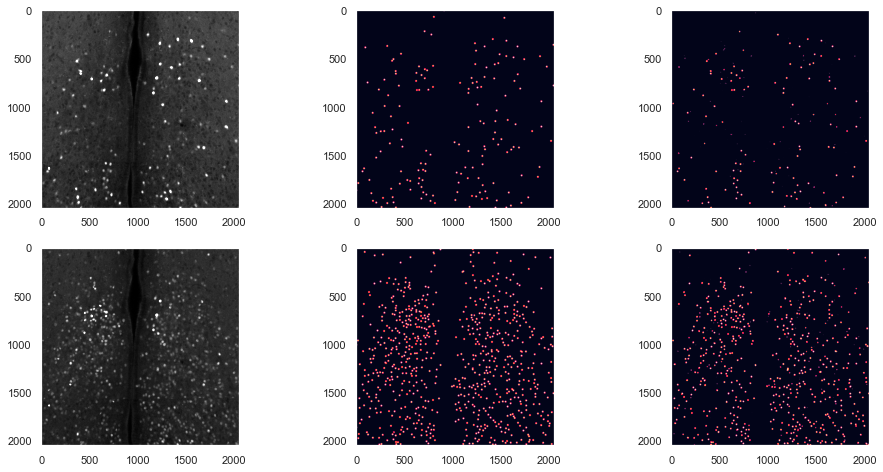

In [5]:
%matplotlib inline
label = 2
plt.figure(figsize=(16,8))

plt.subplot(231)
plt.imshow(im_g,vmin=0,vmax=10,cmap='gray')
ax1 = plt.gca()
plt.grid(False)

plt.subplot(232,sharex=ax1, sharey=ax1)
plt.imshow(np.squeeze(lbl_g),vmin=0,vmax=2)
plt.grid(False)

plt.subplot(233,sharex=ax1, sharey=ax1)
plt.imshow(np.squeeze(pred_g[label,:,:]),vmin=0,vmax=1)
plt.grid(False)

plt.subplot(234,sharex=ax1, sharey=ax1)
plt.imshow(im_r,vmin=0,vmax=10,cmap='gray')
plt.grid(False)

plt.subplot(235,sharex=ax1, sharey=ax1)
plt.imshow(np.squeeze(lbl_r),vmin=0,vmax=2)
plt.grid(False)

plt.subplot(236,sharex=ax1, sharey=ax1)
plt.imshow(np.squeeze(pred_r[label,:,:]),vmin=0,vmax=1)
plt.grid(False)
plt.show()

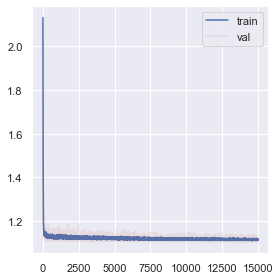

In [6]:
import pandas as pd
log_file='../../../dat/Ai224_RG_models/CE_Adam_run_v0/log.csv'
dat = pd.read_csv(log_file)
plt.figure(figsize=(4,4))
plt.plot(dat['epoch'],dat['train_ce'],'-b',label='train')
plt.plot(dat['epoch'],dat['val_ce'],'-r',alpha=0.1,label='val')
ax = plt.gca()
plt.legend()
plt.tight_layout()
plt.show()